In [1]:
from opty import Problem, create_objective_function, parse_free
import sympy as sp
import numpy as np
import time as ts
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "..")
from importlib import reload

In [2]:
# Equation of motion for 3D double pendulum ###

import sympy.physics.mechanics as me
import sympy as sp

t = sp.symbols('t')
q = me.dynamicsymbols('q1 q2 q3 q4 q5 q6')  # coordinates
u = me.dynamicsymbols('u1 u2 u3 u4 u5 u6')  # angular velocities
# l, m, g, Ixx, Iyy, Izz = sp.symbols('l m g Ixx Iyy Izz')  # 
l = 5
m = 10
g = 9.81
Ixx = 10
Iyy = 1
Izz = 5
F = me.dynamicsymbols('F1:7')

N = me.ReferenceFrame('frame_ground')
N0 = me.Point('point_ground')
N0.set_vel(N,0)

A = me.ReferenceFrame('A')
B = me.ReferenceFrame('B')
frame = [A,B]
mA = me.Point('mA')
mB = me.Point('mB')
ABj = me.Point('ABj')
rot = []
rot1 = []

# rotate joint by quaternion and apply angular velocities
# first joint is in the world frame center
A.orient_body_fixed(N, q[0:3], rotation_order = 'YZY')
# rot.append(A.ang_vel_in(N))
# A.set_ang_vel(N, u[0]*A.x + u[1]*A.y + u[2]*A.z)
# rot1.append(A.ang_vel_in(N))

# set masscenter of the first body
mA.set_pos(N0, -l/2 * A.z)
mA.v2pt_theory(N0,N,A)
FG1 = [(mA, -m * g * N.z)]

# set the position of the joint between the two bodies
ABj.set_pos(N0, -l * A.z)
ABj.v2pt_theory(N0,N,A)

# orient second body from the first body
B.orient_body_fixed(A, q[3:6], rotation_order = 'YZY')
# rot.append(B.ang_vel_in(A))
# B.set_ang_vel(A, u[3]*A.x + u[4]*A.y + u[5]*A.z)
# rot1.append(B.ang_vel_in(A))

mB.set_pos(ABj, -l/2 * B.z)
mB.v2pt_theory(ABj,N,B)
I1 = me.inertia(A, Ixx, Iyy, Izz)
I2 = me.inertia(B, Ixx, Iyy, Izz)

BODY = []
BODY.append(me.RigidBody('Abody', mA, A, m, (I1, mA)))
BODY.append(me.RigidBody('Bbody', mB, B, m, (I2, mB)))

FG2 = [(mB, -m * g * N.z)]
Torque1 = [(A, 500*(F[0]*A.x+F[1]*A.y+F[2]*A.z))]
Torque2 = [(B, 500*(F[3]*B.x+F[4]*B.y+F[5]*B.z))]
kindeq = []
# for i in range(2):
#     for uv in frame[i]:
#         kindeq.append(me.dot(rot[i] - rot1[i], uv))
for i in range(6):
    kindeq.append([q[i].diff()-u[i]])


KM = me.KanesMethod(N, q_ind=q, u_ind=u, kd_eqs=kindeq)
(fr, frstar) = KM.kanes_equations(BODY, (FG1+FG2+Torque1+Torque2))

In [3]:
eoms = sp.Matrix(kindeq).col_join(fr+frstar)

In [4]:
duration = 2 # seconds
num_nodes = 101
interval_value = duration/(num_nodes - 1)
time = np.linspace(0.0, duration, num=num_nodes)
T = me.dynamicsymbols('T')

state_symbols = tuple(q+u)
num_states = len(state_symbols)
num_q = len(q)
specified_symbols = tuple(F)
num_inputs = len(specified_symbols)
t = me.dynamicsymbols._t

In [5]:
import optyEngine as oe
reload (oe);
eul,deul = oe.create_trajectory(num_nodes,duration,interval_value)

In [6]:
eul_traj_guess = np.concatenate((eul,deul)).flatten()

In [7]:
import optyEngine as oe
reload (oe);
objective_traj,objective_traj_jac = oe.objective_function(6,interval_value)
obj_min_diff,obj_min_diff_jac = oe.objective_min_diff(num_nodes,interval_value)

w_traj = 1
w_force = 1e-4
w_diff_vel = 0.01
w_diff_act = 1e-4
node1 = 0
node2 = 50
node3 = num_nodes-1

def obj(free):
    # min_traj = w_traj * np.sum(objective_traj(np.split(free[:3*2*num_nodes],len(q)),eul))
    min_traj = w_traj * (objective_traj(np.array(np.split(free[:6*num_nodes],len(q)))[:,node1],eul[:,node1]) + objective_traj(np.array(np.split(free[:6*num_nodes],len(q)))[:,node2],eul[:,node2]) + objective_traj(np.array(np.split(free[:6*num_nodes],len(q)))[:,node3],eul[:,node3]))
    min_act_dif = w_diff_act * np.sum((obj_min_diff(np.transpose(np.split(free[num_states*num_nodes:(num_states+num_inputs)*num_nodes],num_inputs)))))
    min_vel_dif = w_diff_vel * np.sum((obj_min_diff(np.transpose(np.split(free[num_q*num_nodes:(num_states)*num_nodes],num_q)))))

    # min_vel = w_vel * interval_value * np.sum(free[3*2*num_nodes:6*2*num_nodes]**2)

    min_torque = w_force * interval_value * np.sum(free[num_states*num_nodes:(num_states + num_inputs)*num_nodes]**2)
    return (min_traj + min_torque + min_vel_dif+min_act_dif).item()

def obj_grad(free):
    grad = np.zeros_like(free)
    # grad[:3*2*num_nodes] = w_traj * np.concatenate(objective_traj_jac(np.split(free[:3*2*num_nodes],len(q)),eul))
    grad[num_states*num_nodes:(num_states+num_inputs)*num_nodes] = w_diff_act * np.concatenate(np.transpose((obj_min_diff_jac(np.transpose(np.split(free[num_states*num_nodes:(num_states+num_inputs)*num_nodes],num_inputs)))[0,:,:])))

    first_grad_vals = np.array((objective_traj_jac(np.array(np.split(free[:6*num_nodes],len(q)))[:,node1],eul[:,node1])))
    second_grad_vals = np.array((objective_traj_jac(np.array(np.split(free[:6*num_nodes],len(q)))[:,node2],eul[:,node2])))
    third_grad_vals = np.array((objective_traj_jac(np.array(np.split(free[:6*num_nodes],len(q)))[:,node3],eul[:,node3])))
    grad_traj = np.zeros((num_nodes,6))
    grad_traj[node1,:] = first_grad_vals
    grad_traj[node2,:] = second_grad_vals
    grad_traj[node3,:] = third_grad_vals
    grad[:6*num_nodes] = w_traj * np.concatenate(grad_traj.T)
    
    # grad[3*2*num_nodes:6*2*num_nodes] = w_vel * 2 * interval_value * free[3*2*num_nodes:6*2*num_nodes]
    grad[num_q*num_nodes:(num_states)*num_nodes] = w_diff_vel * np.concatenate(np.transpose((obj_min_diff_jac(np.transpose(np.split(free[num_q*num_nodes:(num_states)*num_nodes],num_inputs)))[0,:,:])))

    grad[num_states*num_nodes:(num_states + num_inputs)*num_nodes] = w_force * 2.0 * interval_value * free[num_states*num_nodes:(num_states + num_inputs)*num_nodes]
    return grad

In [8]:
# w_traj = 100
# w_vel = 0
# w_force = 0.1
# def obj(free):
#     min_traj = w_traj * interval_value * np.sum((eul - free[:3*2*num_nodes])**2)
#     min_vel = w_vel * interval_value * np.sum(free[3*2*num_nodes:6*2*num_nodes]**2)
#     min_torque = w_force * interval_value * np.sum(free[num_states*num_nodes:(num_states + num_inputs)*num_nodes]**2)
#     return min_traj + min_torque + min_vel

# def obj_grad(free):
#     grad = np.zeros_like(free)
#     grad[:3*2*num_nodes] = w_traj * 2.0 * interval_value * (free[:3*2*num_nodes] - eul)
#     grad[3*2*num_nodes:6*2*num_nodes] = w_vel * 2 * interval_value * free[3*2*num_nodes:6*2*num_nodes]
#     grad[num_states*num_nodes:(num_states + num_inputs)*num_nodes] = w_force * 2.0 * interval_value * free[num_states*num_nodes:(num_states + num_inputs)*num_nodes]
#     return grad

In [9]:
instance_constraints = [
    # q[0].func(0.0) - 0.1,
    # # q[1].func(0.0) - 0,
    # q[2].func(0.0) - 0,
    # q[3].func(0.0) - 0,
    # # q[4].func(0.0) - 0,
    # q[5].func(0.0) - 0,
    u[0].func(0.0) - 0,
    u[1].func(0.0) - 0,
    u[2].func(0.0) - 0,
    u[3].func(0.0) - 0,
    u[4].func(0.0) - 0,
    u[5].func(0.0) - 0,
]
instance_constraints = tuple(instance_constraints)

max_force = 50000.0
bounds = {
    F[0]: (-max_force, max_force),
    F[1]: (-max_force, max_force),
    F[2]: (-max_force, max_force),
    F[3]: (-max_force, max_force),
    F[4]: (-max_force, max_force),
    F[5]: (-max_force, max_force),
}

In [10]:
start = ts.time()

prob = Problem(obj, obj_grad, eoms, state_symbols,
               num_nodes, interval_value,
               known_parameter_map={},
               instance_constraints=instance_constraints,
               bounds={},
               time_symbol=t,
               integration_method='midpoint',
)

# prob.add_option('nlp_scaling_method', 'gradient-based')

time_to_create = ts.time() - start
print(time_to_create)

11.004440069198608


In [11]:
initial_guess = np.random.randn(prob.num_free)*0
initial_guess[:6*2*num_nodes] = eul_traj_guess
prob.add_option('max_iter',3000)

In [12]:
start = ts.time()

solution, info = prob.solve(initial_guess)

time_to_create = ts.time() - start
print(time_to_create)

print(info['status_msg'])
print(info['obj_val'])
print('OBJ ACT = ', np.sum(solution[num_states*num_nodes:(num_states + num_inputs)*num_nodes]**2))

1.7840895652770996
b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
0.0006107867167805343
OBJ ACT =  227.82041534844132


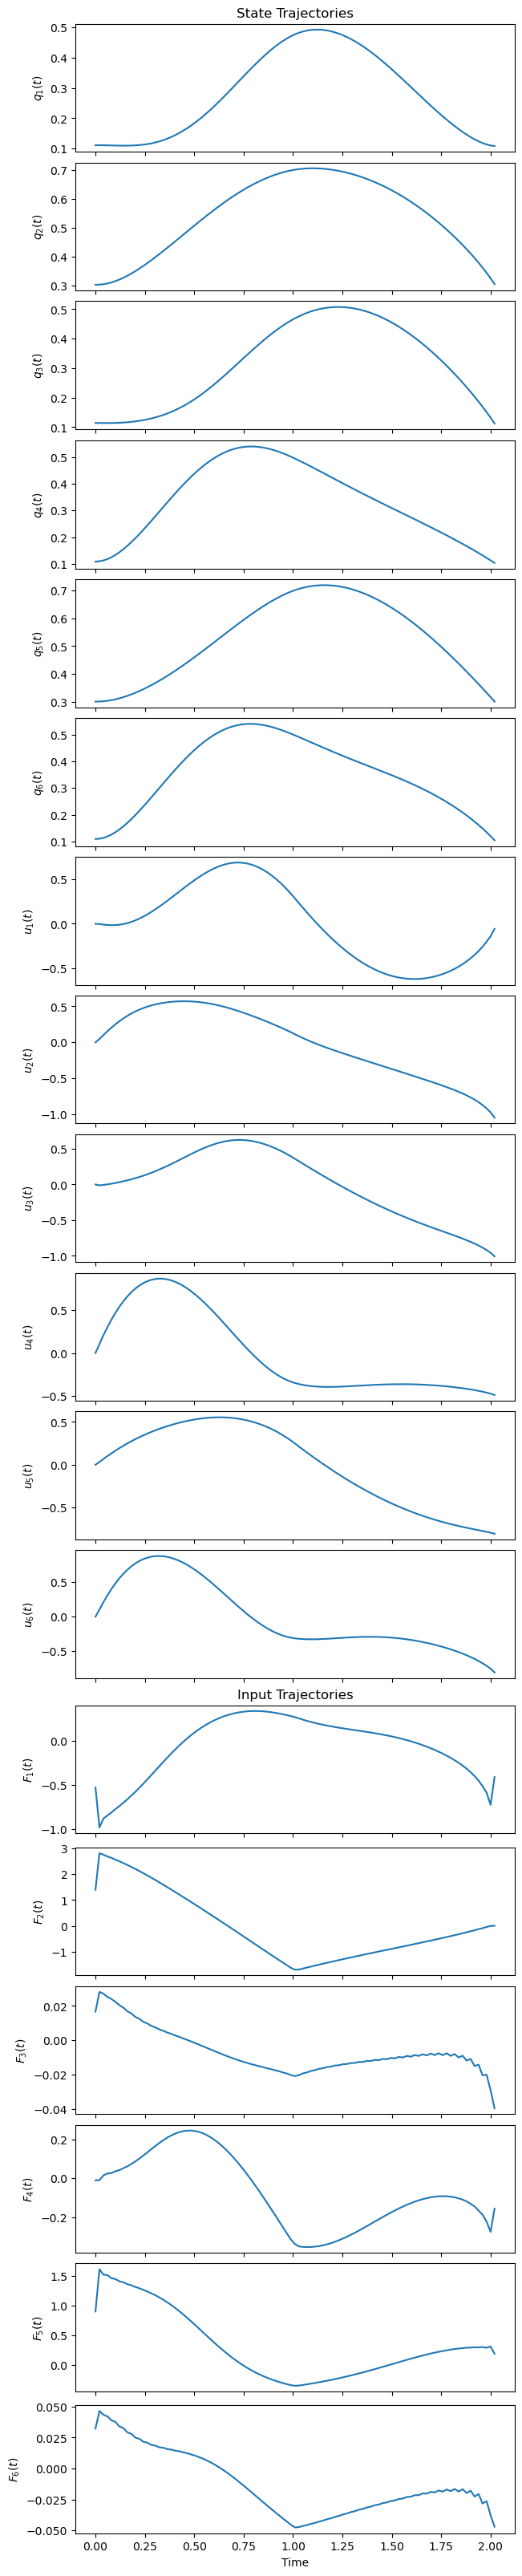

In [13]:
fig, axes = plt.subplots(18, 1, sharex=True,
                         figsize=(6.4, 0.8*40),
                         layout='compressed')
prob.plot_trajectories(solution, axes=axes)

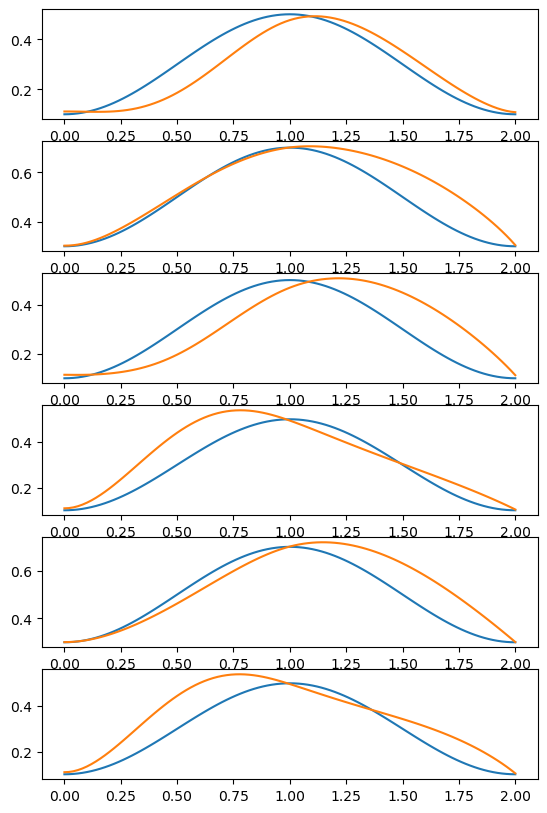

In [14]:
fig, axs = plt.subplots(6)
for j in range(6):
    axs[j].plot(time,eul_traj_guess[j*num_nodes:(j+1)*num_nodes])
    axs[j].plot(time,solution[j*num_nodes:(j+1)*num_nodes])
    fig.set_figheight(10)